In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# plt.style.use('dean_style.conf')

# Examine

In [2]:
scen = 3
scen = 'Scenario' + str(scen)
res = mdl.run_model(
    beta_home = 0.38/9.,
    beta_j=np.array([0.0]*9),
    eps=mdl.eps[scen],
    f=mdl.f0_full[scen],
    days_in_season=1000, 
    alpha=1,
)

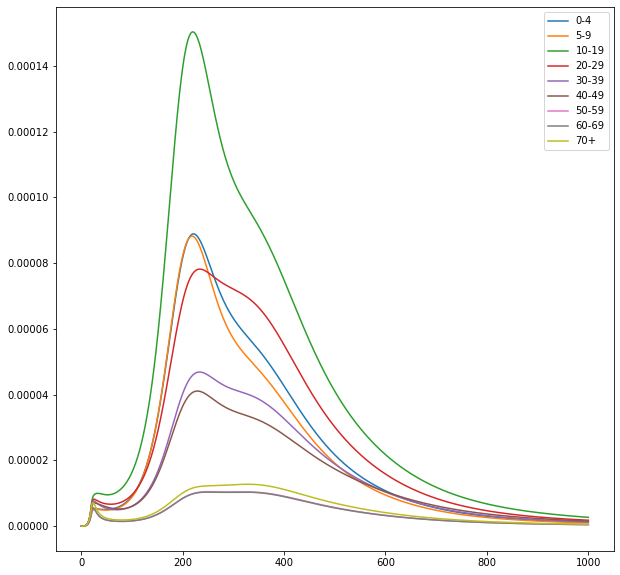

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x4d85f60>)

In [3]:
mdl.plot_I_by_age(res)

In [4]:
res['new_Is'].sum()

0.011361731438174295

# Model calibration

In [2]:
# import data
data = pd.read_csv('../Data/sick/data_IL_age.csv')
data.head()

,date,0-4,5-9,10-19,20-29,30-39,40-49,50-59,60-69,70+
0,21-02-20,4.378280e-09,4.378280e-09,2.189140e-08,5.253940e-08,3.283710e-08,2.845880e-08,3.064800e-08,2.408060e-08,1.970230e-08
1,22-02-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,23-02-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,24-02-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,25-02-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [3]:
data = data[list(mdl.A.values())]

## Calibration with initial I distributed based on population

minimized value: -24.521753948380827
fitted parameters: Beta=[0.         0.0079413  0.04672117 0.04582306 0.19497929]
num of sampling the target function: 179


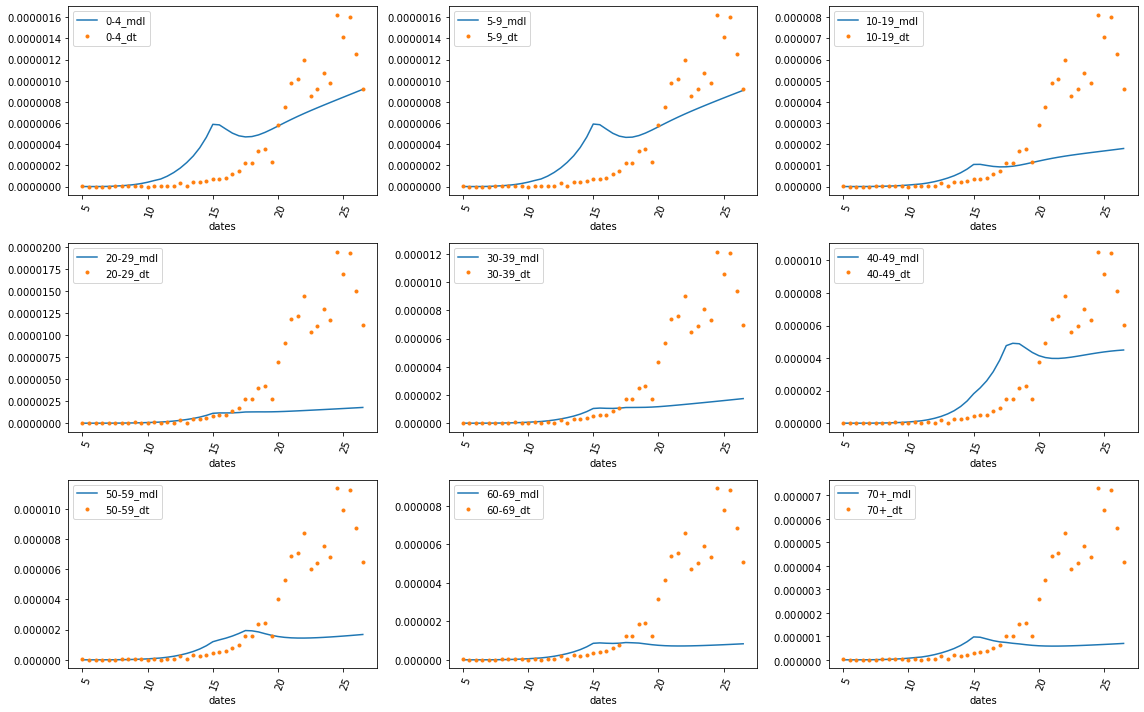

In [5]:
scen = 'Scenario3'
days_in_season=50
alpha=1

# Model Fitting
p0=(0.0568896,0.05063072,0.09070173,0.11419741,0.2) # initial guess
bnds = ((0,0.7),(0,0.7),(0,0.15),(0,0.22),(0,0.25))# boundries for variables
# errorfunc(tpl,data,f,season_length, eps, alpha)
res_fit= optimize.minimize(mdl.errorfunc,
                           p0,bounds=bnds,
                           method='TNC',
                           args=(data.values,
                                 mdl.f0_full[scen],
                                 days_in_season,
                                 mdl.eps[scen],alpha
                                ),
                           options={'maxiter':1000},
                          )

fitted_params = res_fit.x

# run the fitted model:
fitted_beta = np.array([fitted_params[0], fitted_params[0], fitted_params[0], fitted_params[1], fitted_params[1],\
                        fitted_params[2], fitted_params[2], fitted_params[3], fitted_params[3]])
# fitted_beta_home = fitted_params[5]
                        
res_mdl = mdl.run_model(
    beta_home=0.38/9.,
    beta_j=fitted_beta,
    eps=mdl.eps[scen],
    f=mdl.f0_full[scen],
    alpha=alpha,
    days_in_season=days_in_season
)

# plotting the data and model
mdl.print_stat_fit(res_fit)
mdl.plot_calibrated_model(
    data=data.values, 
    mdl_data = res_mdl['new_Is'],
    date_list = data.index.values, 
    season_length=days_in_season,
)